# DDPG - Deep Deterministic Policy Gradients Algorithm


In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## DDPG structure
The algorithm consists of 4 networks. 

- Q Network
- Deterministic policy function
- target Q Network
- target policy network

Using the same principle as described in DQN, 
online networks are used for direct experiences sampled randomly from the replay buffer. 
Target networks are updated every N steps. The difference with DQN is that instead of executing hard update DDPG uses soft one.

DDPG allows to work with continues output, when vanila DQN is not suited for such task

In [2]:
import gym

env = gym.make('Pendulum-v0')
env

<TimeLimit<PendulumEnv<Pendulum-v0>>>

In [3]:
# Random agent

state = env.reset()
done = False

total_reward = 0
while not done:
    action = np.random.random_sample(env.action_space.shape[0])
    state, reward, done, _ = env.step(action)
    total_reward += reward
    env.render()

print(f'Total reward {total_reward}')
env.close()

Total reward -1359.1221190330273


### Actor Network

Actor network is used for constant action on environment. 

In [4]:
import torch.nn.functional as f


class Actor(nn.Module):

    def __init__(self, inputs, outputs, hidden_layers=(128, 256)):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden_layers[0])
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        nn.init.uniform_(self.fc1.bias.data, -f1, f1)

        self.bn1 = nn.LayerNorm(hidden_layers[0])
        self.hidden_layers = nn.ModuleList()
        self.hidden_norms = nn.ModuleList()
        for i in range(len(hidden_layers)-1):
            self.hidden_layers.append(
                nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            fn = 1 / np.sqrt(self.hidden_layers[i].weight.data.size()[0])
            nn.init.uniform_(self.hidden_layers[i].weight.data, -fn, fn)
            nn.init.uniform_(self.hidden_layers[i].bias.data, -fn, fn)
            self.hidden_norms.append(nn.LayerNorm(hidden_layers[i+1]))

        self.output = nn.Linear(hidden_layers[-1], outputs)

    def forward(self, X):
        X = f.relu(self.bn1(self.fc1(X)))
        for i in range(len(self.hidden_layers)):
            X = f.relu(self.hidden_norms[i](self.hidden_layers[i](X)))

        return torch.tanh(self.output(X))


### Critic Network

Critic network is used for criticizing Actor by soft updates every once in awhile.

In [5]:
class Critic(nn.Module):

    def __init__(self, inputs, outputs, hidden_layers=(128, 256)):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden_layers[0])
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        nn.init.uniform_(self.fc1.bias.data, -f1, f1)

        self.bn1 = nn.LayerNorm(hidden_layers[0])
        self.hidden_layers = nn.ModuleList()
        self.hidden_norms = nn.ModuleList()
        for i in range(len(hidden_layers)-1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            fn = 1 / np.sqrt(self.hidden_layers[i].weight.data.size()[0])
            nn.init.uniform_(self.hidden_layers[i].weight.data, -fn, fn)
            nn.init.uniform_(self.hidden_layers[i].bias.data, -fn, fn)
            self.hidden_norms.append(nn.LayerNorm(hidden_layers[i+1]))
        self.output = nn.Linear(hidden_layers[-1], outputs)

    def forward(self, X1, X2):
        X = torch.cat([X1, X2], 1) # concatenate states and actions by columns
        X = f.relu(self.bn1(self.fc1(X)))
        for i in range(len(self.hidden_layers)):
            X = f.relu(self.hidden_norms[i](self.hidden_layers[i](X)))
        
        return self.output(X)

### Replay Buffer

Replay Buffer serves as a storage for sampling data points. Samples are drawn randomly to achieve IID - Independent and Identical Distribution

In [6]:
from collections import deque
import random

class ReplayBuffer():

    def __init__(self, cap=128):
        self.buffer = deque(maxlen=cap)

    def add(self, state, action, reward, next_state, done):
        exp = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(exp)
        

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.vstack(states), np.vstack(actions), np.vstack(rewards), np.vstack(next_states), np.vstack(dones)

    def __len__(self):
        return len(self.buffer)


In [7]:
# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [8]:
class Utils:

    @staticmethod
    def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    @staticmethod
    def hard_update(target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [11]:
class Agent:

    def __init__(self, state_size, action_size, net_dim=(256, 256), buffer_size=50_000, batch_size=64, gamma=0.99, tau=1e-2, actor_lr=1e-4, critic_lr=1e-3, device='cpu'):
        self.actor = Actor(state_size, action_size, hidden_layers=net_dim)
        self.actor_target = Actor(
            state_size, action_size, hidden_layers=net_dim)

        self.critic = Critic(state_size + action_size,
                             action_size, hidden_layers=net_dim)
        self.critic_target = Critic(
            state_size + action_size, action_size, hidden_layers=net_dim)

        Utils.hard_update(self.actor_target, self.actor)
        Utils.hard_update(self.critic_target, self.critic)

        self.buffer = ReplayBuffer(cap=buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.criterion = nn.MSELoss()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), lr=critic_lr)

        self.device = torch.device(device)
        self.actor.to(self.device)
        self.actor_target.to(self.device)
        self.critic.to(self.device)
        self.critic_target.to(self.device)

    def step(self):
        if len(self.buffer) < self.batch_size:
            return
            
        states, actions, rewards, next_states, _ = self.buffer.sample(
            self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)

        qval = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        nextQ = self.critic_target.forward(next_states, next_actions.detach())
        qprime = rewards + self.gamma * nextQ

        critic_loss = self.criterion(qval, qprime)
        actor_loss = - \
            self.critic.forward(states, self.actor.forward(states)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        Utils.soft_update(self.actor_target, self.actor, self.tau)
        Utils.soft_update(self.critic_target, self.critic, self.tau)

    @torch.no_grad()
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        action = self.actor.forward(state)
        return action.cpu().detach().numpy()[0]

    def push(self, state, action, reward, next_state, done):
        self.buffer.add(state, action, reward, next_state, done)

    def save(self, path):
        torch.save(self.actor.state_dict(), path + '_actor.pth')
        torch.save(self.critic.state_dict(), path + '_critic.pth')
        torch.save(self.actor_target.state_dict(), path + '_actor_target.pth')
        torch.save(self.critic_target.state_dict(), path + '_critic_target.pth')


Episode 49 reward -389.46454428098877

Text(0, 0.5, 'Reward')

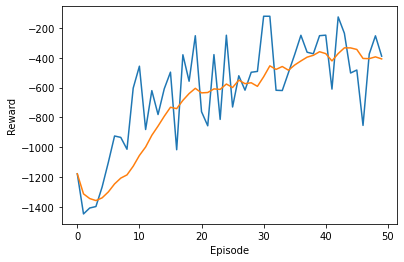

In [12]:
import torch.optim as optim

# traning routine
EPISODES = 50

env = gym.make("Pendulum-v0") 
noise = OUNoise(env.action_space)

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
agent = Agent(num_states, num_actions, device=device)

rewards = []
avg_rewards = []
total_steps = 0
for i in range(EPISODES):
    state = env.reset()
    noise.reset()
    ep_reward = 0
    step = 0
    while True:
        step += 1
        total_steps += 1
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        next_state, reward, done, _ = env.step(action)

        # add new data to replay buffer
        agent.push(state, action, reward, next_state, done)
        agent.step()

        ep_reward += reward
        state = next_state
        if done:
            break

    print(f'\rEpisode {i} reward {ep_reward}', end='')
    rewards.append(ep_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    if avg_rewards[-1] > -250:
        print(f'Early stop at episode {i}')
        break
    
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')

Total reward: -238.16646684814265

Text(0, 0.5, 'Reward')

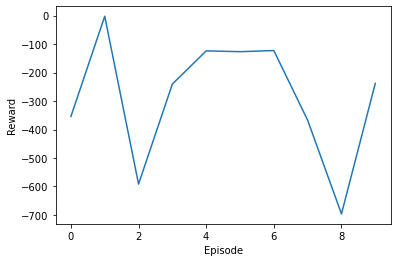

In [19]:
# Evaluation 

total_rewards = []
for _ in range(10):
    state = env.reset()
    ep_reward = 0
    while True:
        # state = torch.from_numpy(state).float().unsqueeze(0) #.to(device)
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        ep_reward += reward
        state = next_state
        env.render()
        if done:
            break

    print(f'\rTotal reward: {ep_reward}', end='')
    total_rewards.append(ep_reward)

env.close()
plt.plot(total_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')